In [1]:
from __future__ import print_function
from __future__ import division
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
import pandas as pd
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

/home/Jagan/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


In [2]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave

In [4]:
from PIL import Image

In [5]:
image = Image.open('swim.jpg')

In [6]:
image.format, image.size, image.mode

('PNG', (400, 400), 'RGBA')

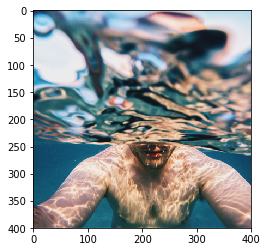

In [7]:
plt.imshow(image)

In [8]:
from torchvision.transforms import Lambda

In [9]:
def transform_rgb2lab(image):
    image = image.convert("RGB")
    image = np.asarray(image)
    image = rgb2lab(image/255)
    return image

In [10]:
transform = transforms.Compose([Lambda(lambda image: transform_rgb2lab(image)),
                                transforms.ToTensor()
                               ])

In [11]:
image = transform(image)

In [12]:
image.shape

torch.Size([3, 400, 400])

In [13]:
pd.Series(np.squeeze(image.numpy().reshape(-1,1))).describe()

count    480000.000000
mean         18.301763
std          31.231857
min         -41.524839
25%          -5.072442
50%           8.484545
75%          35.773458
max          94.158473
dtype: float64

In [14]:
pd.Series(np.squeeze(image.numpy()[0].reshape(-1,1))).describe()

count    160000.000000
mean         55.601933
std          23.465292
min           5.061775
25%          35.727932
50%          55.688496
75%          76.901396
max          94.158473
dtype: float64

In [15]:
pd.Series(np.squeeze(image.numpy()[1:].reshape(-1,1))).describe()

count    320000.000000
mean         -0.348321
std          12.014803
min         -41.524839
25%          -9.114776
50%          -0.822109
75%           8.753830
max          48.480128
dtype: float64

In [16]:
X = image[0,:,:]
Y = image[1:,:,:]/128

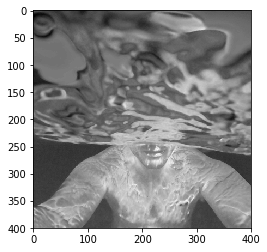

In [17]:
plt.imshow(Y[1], cmap='gray')

In [18]:
import torch.nn.functional as F

- The weights are `xavier_uniform` == `glorot_uniform` in Keras
- The default bias in Keras is 0.

In [19]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [20]:
class ColorNetAlpha(nn.Module):
    def __init__(self):
        super(ColorNetAlpha, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, (3,3), stride=2)
        self.conv2 = nn.Conv2d(8, 8, (3,3), stride=1)
        self.conv3 = nn.Conv2d(8, 16, (3,3), stride=1)
        self.conv4 = nn.Conv2d(16, 16, (3,3), stride=2)
        self.conv5 = nn.Conv2d(16, 32, (3,3), stride=1)
        self.conv6 = nn.Conv2d(32, 32, (3,3), stride=2)
        self.upsample7 = nn.Upsample(scale_factor=(2,2))
        self.conv8 = nn.Conv2d(32, 32, (3,3), stride=1)
        self.upsample9 = nn.Upsample(scale_factor=(2,2))
        self.conv10 = nn.Conv2d(32, 16, (3,3), stride=1)
        self.upsample11 = nn.Upsample(scale_factor=(2,2))
        self.conv12 = nn.Conv2d(16, 2, (3,3), stride=1)
   
    def same_pad(self, input, k=(3,3), d=(1,1), s=(1,1)):
        
        i = (input.size(-2), input.size(-1))
        # i = (i_H, i_W)
        # k = (k_H, k_W)
        # d = (d, d); dilation
        # s = (s, s); stride
        
        # tensorflow style - same padding output calculation
        calc_eff_k = lambda k, d: (k - 1) * d + 1
        k = tuple([calc_eff_k(x, y) for x, y in zip(k, d)])
        calc_o = lambda i, s: np.ceil(i/s)
        o = tuple([calc_o(x, y) for x, y in zip(i, s)])
        calc_p = lambda o, s, k, i: max(0, (o-1)*s + k-i)
        p = tuple([calc_p(w, x, y, z) for w, x, y, z in zip(o, s, k, i)])
                               
        # left, right , up , bottom
        padding = [p[1]//2, p[1]//2 + p[1]%2, p[0]//2, p[0]//2 + p[0]%2]
        padding = [int(p) for p in padding]
        return F.pad(input, padding)

    def forward(self, x):
        x = F.relu(self.conv1(self.same_pad(x, s=(2, 2))))
        x = F.relu(self.conv2(self.same_pad(x)))
        x = F.relu(self.conv3(self.same_pad(x)))
        x = F.relu(self.conv4(self.same_pad(x, s=(2, 2))))
        x = F.relu(self.conv5(self.same_pad(x)))
        x = F.relu(self.conv6(self.same_pad(x, s=(2, 2))))
        x = self.upsample7(x)
        x = F.relu(self.conv8(self.same_pad(x)))
        x = self.upsample9(x)
        x = F.relu(self.conv10(self.same_pad(x)))
        x = self.upsample11(x)
        x = torch.tanh(self.conv12(self.same_pad(x)))
        
        return x

In [21]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [22]:
net = ColorNetAlpha()

In [23]:
net.apply(weights_init)

ColorNetAlpha(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (upsample7): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (upsample9): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv10): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (upsample11): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv12): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1))
)

In [24]:
net.to(device)

ColorNetAlpha(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (upsample7): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (upsample9): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv10): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (upsample11): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv12): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1))
)

In [25]:
criterion = nn.MSELoss()

In [26]:
optimizer = optim.RMSprop(net.parameters(), lr=0.0001, momentum=0.9)

### Training Loop

In [27]:
from tqdm import tqdm

In [28]:
for epoch in tqdm(range(1000)):  
    running_loss = 0.0
    # get the inputs
    inputs, labels = X.view(1, 1, 400, 400).float(), Y.view(1, 2 , 400, 400).float()
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 5 == 4:    # print every 4 epochs
        print(f'epoch: {epoch + 1}, loss: {running_loss / 4}')
        running_loss = 0.0

print('Finished Training')

  0%|          | 0/1000 [00:00<?, ?it/s]/home/Jagan/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
  1%|          | 8/1000 [00:00<00:55, 17.87it/s]

epoch: 5, loss: 0.0021823712158948183


  1%|▏         | 14/1000 [00:00<00:50, 19.50it/s]

epoch: 10, loss: 0.0021380046382546425


  2%|▏         | 17/1000 [00:00<00:48, 20.20it/s]

epoch: 15, loss: 0.0019970210269093513


  2%|▏         | 23/1000 [00:01<00:46, 21.22it/s]

epoch: 20, loss: 0.001771667506545782


  3%|▎         | 29/1000 [00:01<00:44, 21.88it/s]

epoch: 25, loss: 0.0014798613265156746


  3%|▎         | 32/1000 [00:01<00:43, 22.11it/s]

epoch: 30, loss: 0.0013361169258132577


  4%|▍         | 38/1000 [00:01<00:42, 22.49it/s]

epoch: 35, loss: 0.0012535627465695143


  4%|▍         | 44/1000 [00:01<00:41, 22.78it/s]

epoch: 40, loss: 0.0011774355079978704


  5%|▍         | 47/1000 [00:02<00:41, 22.90it/s]

epoch: 45, loss: 0.0011365188984200358


  5%|▌         | 53/1000 [00:02<00:41, 23.10it/s]

epoch: 50, loss: 0.001054938300512731


  6%|▌         | 59/1000 [00:02<00:40, 23.26it/s]

epoch: 55, loss: 0.0010080747306346893


  6%|▌         | 62/1000 [00:02<00:40, 23.33it/s]

epoch: 60, loss: 0.0009442023001611233


  7%|▋         | 68/1000 [00:02<00:39, 23.44it/s]

epoch: 65, loss: 0.0008882312686182559


  7%|▋         | 74/1000 [00:03<00:39, 23.54it/s]

epoch: 70, loss: 0.0008257963345386088


  8%|▊         | 77/1000 [00:03<00:39, 23.58it/s]

epoch: 75, loss: 0.0007637437665835023


  8%|▊         | 83/1000 [00:03<00:38, 23.66it/s]

epoch: 80, loss: 0.0007137999054975808
epoch: 85, loss: 0.0006509526283480227


 10%|▉         | 95/1000 [00:03<00:37, 23.82it/s]

epoch: 90, loss: 0.0006378075340762734
epoch: 95, loss: 0.000605291104875505


 10%|█         | 104/1000 [00:04<00:37, 23.90it/s]

epoch: 100, loss: 0.0005453983903862536


 11%|█         | 110/1000 [00:04<00:37, 23.94it/s]

epoch: 105, loss: 0.0005277200252749026
epoch: 110, loss: 0.0004934426979161799


 12%|█▏        | 119/1000 [00:04<00:36, 24.00it/s]

epoch: 115, loss: 0.0004772953107021749
epoch: 120, loss: 0.0004591374017763883


 13%|█▎        | 128/1000 [00:05<00:36, 24.06it/s]

epoch: 125, loss: 0.0004402601334732026


 13%|█▎        | 134/1000 [00:05<00:35, 24.09it/s]

epoch: 130, loss: 0.0004231127677485347


 14%|█▍        | 140/1000 [00:05<00:35, 24.12it/s]

epoch: 135, loss: 0.00041007623076438904
epoch: 140, loss: 0.00042605839553289115


 15%|█▍        | 149/1000 [00:06<00:35, 24.17it/s]

epoch: 145, loss: 0.0004017807950731367


 16%|█▌        | 155/1000 [00:06<00:34, 24.19it/s]

epoch: 150, loss: 0.00038041340303607285
epoch: 155, loss: 0.0003652354353107512


 16%|█▋        | 164/1000 [00:06<00:34, 24.22it/s]

epoch: 160, loss: 0.00035453782766126096


 17%|█▋        | 170/1000 [00:07<00:34, 24.25it/s]

epoch: 165, loss: 0.00034667845466174185
epoch: 170, loss: 0.00033743714448064566


 18%|█▊        | 179/1000 [00:07<00:33, 24.28it/s]

epoch: 175, loss: 0.0003300518437754363


 18%|█▊        | 182/1000 [00:07<00:33, 24.28it/s]

epoch: 180, loss: 0.00031891101389192045


 19%|█▉        | 188/1000 [00:07<00:33, 24.30it/s]

epoch: 185, loss: 0.0003128267708234489


 19%|█▉        | 194/1000 [00:07<00:33, 24.31it/s]

epoch: 190, loss: 0.00035292733809910715


 20%|█▉        | 197/1000 [00:08<00:33, 24.32it/s]

epoch: 195, loss: 0.00030039253761060536


 20%|██        | 203/1000 [00:08<00:32, 24.33it/s]

epoch: 200, loss: 0.00029884566902182996


 21%|██        | 209/1000 [00:08<00:32, 24.34it/s]

epoch: 205, loss: 0.0002923819120042026


 21%|██        | 212/1000 [00:08<00:32, 24.35it/s]

epoch: 210, loss: 0.0002812629973050207


 22%|██▏       | 218/1000 [00:08<00:32, 24.36it/s]

epoch: 215, loss: 0.0002758915943559259


 22%|██▏       | 224/1000 [00:09<00:31, 24.37it/s]

epoch: 220, loss: 0.00026980970869772136


 23%|██▎       | 227/1000 [00:09<00:31, 24.37it/s]

epoch: 225, loss: 0.0002638663863763213


 23%|██▎       | 233/1000 [00:09<00:31, 24.38it/s]

epoch: 230, loss: 0.00026088202139362693


 24%|██▍       | 239/1000 [00:09<00:31, 24.40it/s]

epoch: 235, loss: 0.00025508031831122935
epoch: 240, loss: 0.00025313496007584035


 25%|██▍       | 248/1000 [00:10<00:30, 24.41it/s]

epoch: 245, loss: 0.0002858587249647826


 25%|██▌       | 254/1000 [00:10<00:30, 24.42it/s]

epoch: 250, loss: 0.00025304165319539607


 26%|██▌       | 257/1000 [00:10<00:30, 24.42it/s]

epoch: 255, loss: 0.0002398787037236616


 26%|██▋       | 263/1000 [00:10<00:30, 24.43it/s]

epoch: 260, loss: 0.0002438625815557316


 27%|██▋       | 269/1000 [00:11<00:29, 24.44it/s]

epoch: 265, loss: 0.00023616738326381892


 27%|██▋       | 272/1000 [00:11<00:29, 24.44it/s]

epoch: 270, loss: 0.00023000221699476242


 28%|██▊       | 278/1000 [00:11<00:29, 24.44it/s]

epoch: 275, loss: 0.00022589170839637518


 28%|██▊       | 284/1000 [00:11<00:29, 24.45it/s]

epoch: 280, loss: 0.00022311568318400532


 29%|██▉       | 290/1000 [00:11<00:29, 24.45it/s]

epoch: 285, loss: 0.0002184397162636742
epoch: 290, loss: 0.00021945891785435379


 30%|██▉       | 299/1000 [00:12<00:28, 24.46it/s]

epoch: 295, loss: 0.00023511795734521002


 30%|███       | 302/1000 [00:12<00:28, 24.47it/s]

epoch: 300, loss: 0.0002217314176959917


 31%|███       | 308/1000 [00:12<00:28, 24.47it/s]

epoch: 305, loss: 0.00021288856805767864


 31%|███▏      | 314/1000 [00:12<00:28, 24.47it/s]

epoch: 310, loss: 0.00020499134552665055


 32%|███▏      | 317/1000 [00:12<00:27, 24.48it/s]

epoch: 315, loss: 0.00020302095799706876


 32%|███▏      | 323/1000 [00:13<00:27, 24.48it/s]

epoch: 320, loss: 0.0002033076307270676


 33%|███▎      | 329/1000 [00:13<00:27, 24.49it/s]

epoch: 325, loss: 0.000200165159185417


 34%|███▎      | 335/1000 [00:13<00:27, 24.49it/s]

epoch: 330, loss: 0.0001948444260051474
epoch: 335, loss: 0.0001930231519509107


 34%|███▍      | 344/1000 [00:14<00:26, 24.50it/s]

epoch: 340, loss: 0.0002498841204214841


 35%|███▍      | 347/1000 [00:14<00:26, 24.50it/s]

epoch: 345, loss: 0.0002376581687713042


 35%|███▌      | 353/1000 [00:14<00:26, 24.50it/s]

epoch: 350, loss: 0.000197064655367285


 36%|███▌      | 359/1000 [00:14<00:26, 24.51it/s]

epoch: 355, loss: 0.00018817675299942493


 36%|███▌      | 362/1000 [00:14<00:26, 24.51it/s]

epoch: 360, loss: 0.00019186956342309713


 37%|███▋      | 368/1000 [00:15<00:25, 24.51it/s]

epoch: 365, loss: 0.00018458325939718634


 37%|███▋      | 374/1000 [00:15<00:25, 24.52it/s]

epoch: 370, loss: 0.00018290695152245462


 38%|███▊      | 377/1000 [00:15<00:25, 24.52it/s]

epoch: 375, loss: 0.00017981902055907995


 38%|███▊      | 383/1000 [00:15<00:25, 24.52it/s]

epoch: 380, loss: 0.0001773856347426772


 39%|███▉      | 389/1000 [00:15<00:24, 24.53it/s]

epoch: 385, loss: 0.00017495818610768765


 40%|███▉      | 395/1000 [00:16<00:24, 24.53it/s]

epoch: 390, loss: 0.00017312307318206877
epoch: 395, loss: 0.00017161255527753383


 40%|████      | 404/1000 [00:16<00:24, 24.54it/s]

epoch: 400, loss: 0.00016973583842627704


 41%|████      | 407/1000 [00:16<00:24, 24.54it/s]

epoch: 405, loss: 0.00016854879504535347


 42%|████▏     | 419/1000 [00:17<00:23, 24.55it/s]

epoch: 410, loss: 0.00018667473341338336
epoch: 415, loss: 0.00016899150796234608


 42%|████▏     | 422/1000 [00:17<00:23, 24.55it/s]

epoch: 420, loss: 0.00017747783567756414


 43%|████▎     | 434/1000 [00:17<00:23, 24.55it/s]

epoch: 425, loss: 0.00017093312635552138
epoch: 430, loss: 0.00016266750753857195


 44%|████▍     | 440/1000 [00:17<00:22, 24.56it/s]

epoch: 435, loss: 0.0001610594626981765
epoch: 440, loss: 0.00015950198576319963


 45%|████▍     | 449/1000 [00:18<00:22, 24.56it/s]

epoch: 445, loss: 0.00015784561401233077


 46%|████▌     | 455/1000 [00:18<00:22, 24.57it/s]

epoch: 450, loss: 0.0001575098285684362
epoch: 455, loss: 0.0001550680462969467


 46%|████▋     | 464/1000 [00:18<00:21, 24.57it/s]

epoch: 460, loss: 0.00015718984650447965


 47%|████▋     | 467/1000 [00:19<00:21, 24.57it/s]

epoch: 465, loss: 0.00019912203424610198
epoch: 470, loss: 0.0001679101405898109


 48%|████▊     | 479/1000 [00:19<00:21, 24.58it/s]

epoch: 475, loss: 0.00015399065159726888
epoch: 480, loss: 0.00015324367268476635


 49%|████▉     | 488/1000 [00:19<00:20, 24.58it/s]

epoch: 485, loss: 0.00015338270168285817


 49%|████▉     | 494/1000 [00:20<00:20, 24.59it/s]

epoch: 490, loss: 0.00015180172340478748


 50%|█████     | 500/1000 [00:20<00:20, 24.59it/s]

epoch: 495, loss: 0.00014965164882596582
epoch: 500, loss: 0.00014693227421958


 51%|█████     | 509/1000 [00:20<00:19, 24.59it/s]

epoch: 505, loss: 0.00014582717267330736


 51%|█████     | 512/1000 [00:20<00:19, 24.59it/s]

epoch: 510, loss: 0.0001436827442375943


 52%|█████▏    | 518/1000 [00:21<00:19, 24.60it/s]

epoch: 515, loss: 0.0001426648086635396


 52%|█████▏    | 524/1000 [00:21<00:19, 24.60it/s]

epoch: 520, loss: 0.00015067575441207737


 53%|█████▎    | 530/1000 [00:21<00:19, 24.60it/s]

epoch: 525, loss: 0.00014495899085886776
epoch: 530, loss: 0.00018264722893945873


 54%|█████▍    | 539/1000 [00:21<00:18, 24.60it/s]

epoch: 535, loss: 0.0001713516830932349


 55%|█████▍    | 545/1000 [00:22<00:18, 24.61it/s]

epoch: 540, loss: 0.00015409465413540602
epoch: 545, loss: 0.00014474737690761685


 55%|█████▌    | 554/1000 [00:22<00:18, 24.61it/s]

epoch: 550, loss: 0.00013872660929337144


 56%|█████▌    | 557/1000 [00:22<00:18, 24.61it/s]

epoch: 555, loss: 0.00013905730156693608


 56%|█████▋    | 563/1000 [00:22<00:17, 24.61it/s]

epoch: 560, loss: 0.00013818593288306147


 57%|█████▋    | 569/1000 [00:23<00:17, 24.61it/s]

epoch: 565, loss: 0.00013585739361587912


 57%|█████▋    | 572/1000 [00:23<00:17, 24.61it/s]

epoch: 570, loss: 0.00013500584464054555


 58%|█████▊    | 578/1000 [00:23<00:17, 24.61it/s]

epoch: 575, loss: 0.00013381811731960624


 58%|█████▊    | 584/1000 [00:23<00:16, 24.62it/s]

epoch: 580, loss: 0.00013286010653246194


 59%|█████▉    | 590/1000 [00:23<00:16, 24.62it/s]

epoch: 585, loss: 0.0001319825678365305
epoch: 590, loss: 0.0001311867090407759


 60%|█████▉    | 599/1000 [00:24<00:16, 24.62it/s]

epoch: 595, loss: 0.0001303272438235581


 60%|██████    | 605/1000 [00:24<00:16, 24.62it/s]

epoch: 600, loss: 0.00012961312313564122
epoch: 605, loss: 0.00013258185936138034


 61%|██████▏   | 614/1000 [00:24<00:15, 24.62it/s]

epoch: 610, loss: 0.00016382522881031036


 62%|██████▏   | 617/1000 [00:25<00:15, 24.62it/s]

epoch: 615, loss: 0.00013495146413333714


 63%|██████▎   | 629/1000 [00:25<00:15, 24.62it/s]

epoch: 620, loss: 0.0001295835681958124
epoch: 625, loss: 0.000133811729028821


 63%|██████▎   | 632/1000 [00:25<00:14, 24.62it/s]

epoch: 630, loss: 0.0001281016884604469


 64%|██████▍   | 638/1000 [00:25<00:14, 24.63it/s]

epoch: 635, loss: 0.00012515847629401833


 64%|██████▍   | 644/1000 [00:26<00:14, 24.63it/s]

epoch: 640, loss: 0.00012434172094799578


 65%|██████▍   | 647/1000 [00:26<00:14, 24.63it/s]

epoch: 645, loss: 0.00012370261538308114


 65%|██████▌   | 653/1000 [00:26<00:14, 24.63it/s]

epoch: 650, loss: 0.0001250131899723783


 66%|██████▌   | 659/1000 [00:26<00:13, 24.63it/s]

epoch: 655, loss: 0.00012246468395460397


 66%|██████▌   | 662/1000 [00:26<00:13, 24.63it/s]

epoch: 660, loss: 0.00013038638280704618


 67%|██████▋   | 668/1000 [00:27<00:13, 24.63it/s]

epoch: 665, loss: 0.0001331332023255527


 67%|██████▋   | 674/1000 [00:27<00:13, 24.63it/s]

epoch: 670, loss: 0.00012650682765524834


 68%|██████▊   | 677/1000 [00:27<00:13, 24.63it/s]

epoch: 675, loss: 0.00012581082410179079


 68%|██████▊   | 683/1000 [00:27<00:12, 24.63it/s]

epoch: 680, loss: 0.00012413332297001034


 69%|██████▉   | 689/1000 [00:27<00:12, 24.64it/s]

epoch: 685, loss: 0.0001214348230860196


 69%|██████▉   | 692/1000 [00:28<00:12, 24.64it/s]

epoch: 690, loss: 0.00011871493188664317


 70%|██████▉   | 698/1000 [00:28<00:12, 24.64it/s]

epoch: 695, loss: 0.00011902856931556016


 70%|███████   | 704/1000 [00:28<00:12, 24.64it/s]

epoch: 700, loss: 0.00012053859245497733


 71%|███████   | 707/1000 [00:28<00:11, 24.64it/s]

epoch: 705, loss: 0.00013930613931734115


 71%|███████▏  | 713/1000 [00:28<00:11, 24.64it/s]

epoch: 710, loss: 0.00012195620365673676


 72%|███████▏  | 719/1000 [00:29<00:11, 24.64it/s]

epoch: 715, loss: 0.00011766805982915685


 72%|███████▏  | 722/1000 [00:29<00:11, 24.64it/s]

epoch: 720, loss: 0.00011604900646489114


 73%|███████▎  | 728/1000 [00:29<00:11, 24.64it/s]

epoch: 725, loss: 0.0001143577610491775


 73%|███████▎  | 734/1000 [00:29<00:10, 24.64it/s]

epoch: 730, loss: 0.00011524541332619265


 74%|███████▍  | 740/1000 [00:30<00:10, 24.64it/s]

epoch: 735, loss: 0.00011439224181231111
epoch: 740, loss: 0.00011929770698770881


 75%|███████▍  | 749/1000 [00:30<00:10, 24.64it/s]

epoch: 745, loss: 0.00012288046127650887


 75%|███████▌  | 752/1000 [00:30<00:10, 24.64it/s]

epoch: 750, loss: 0.00011622867896221578


 76%|███████▌  | 758/1000 [00:30<00:09, 24.65it/s]

epoch: 755, loss: 0.00011209807416889817


 76%|███████▋  | 764/1000 [00:30<00:09, 24.65it/s]

epoch: 760, loss: 0.00011561844439711422


 77%|███████▋  | 767/1000 [00:31<00:09, 24.65it/s]

epoch: 765, loss: 0.00011259715392952785


 77%|███████▋  | 773/1000 [00:31<00:09, 24.65it/s]

epoch: 770, loss: 0.00011054117931053042


 78%|███████▊  | 779/1000 [00:31<00:08, 24.65it/s]

epoch: 775, loss: 0.00012356929073575884


 78%|███████▊  | 782/1000 [00:31<00:08, 24.65it/s]

epoch: 780, loss: 0.0001121987952501513


 79%|███████▉  | 788/1000 [00:31<00:08, 24.65it/s]

epoch: 785, loss: 0.00011569209164008498


 79%|███████▉  | 794/1000 [00:32<00:08, 24.65it/s]

epoch: 790, loss: 0.00011654031550278887


 80%|███████▉  | 797/1000 [00:32<00:08, 24.65it/s]

epoch: 795, loss: 0.00011068231833633035


 80%|████████  | 803/1000 [00:32<00:07, 24.65it/s]

epoch: 800, loss: 0.00010800224845297635


 81%|████████  | 809/1000 [00:32<00:07, 24.65it/s]

epoch: 805, loss: 0.00010747145279310644


 81%|████████  | 812/1000 [00:32<00:07, 24.65it/s]

epoch: 810, loss: 0.00010687152098398656


 82%|████████▏ | 818/1000 [00:33<00:07, 24.65it/s]

epoch: 815, loss: 0.00010581295646261424


 82%|████████▏ | 824/1000 [00:33<00:07, 24.65it/s]

epoch: 820, loss: 0.00010586455027805641


 83%|████████▎ | 827/1000 [00:33<00:07, 24.65it/s]

epoch: 825, loss: 0.0001059508795151487


 83%|████████▎ | 833/1000 [00:33<00:06, 24.65it/s]

epoch: 830, loss: 0.00011949114559683949


 84%|████████▍ | 839/1000 [00:34<00:06, 24.65it/s]

epoch: 835, loss: 0.00010604868293739855


 84%|████████▍ | 842/1000 [00:34<00:06, 24.65it/s]

epoch: 840, loss: 0.00010783916513901204


 85%|████████▍ | 848/1000 [00:34<00:06, 24.65it/s]

epoch: 845, loss: 0.0001091393205570057


 85%|████████▌ | 854/1000 [00:34<00:05, 24.65it/s]

epoch: 850, loss: 0.00010780058801174164


 86%|████████▌ | 860/1000 [00:34<00:05, 24.65it/s]

epoch: 855, loss: 0.00010521293006604537
epoch: 860, loss: 0.00010292913793819025


 87%|████████▋ | 869/1000 [00:35<00:05, 24.65it/s]

epoch: 865, loss: 0.00010273523366777226


 87%|████████▋ | 872/1000 [00:35<00:05, 24.66it/s]

epoch: 870, loss: 0.00010188962187385187


 88%|████████▊ | 878/1000 [00:35<00:04, 24.66it/s]

epoch: 875, loss: 0.00010288658086210489


 88%|████████▊ | 884/1000 [00:35<00:04, 24.66it/s]

epoch: 880, loss: 0.0001371343241771683


 89%|████████▉ | 890/1000 [00:36<00:04, 24.66it/s]

epoch: 885, loss: 0.00011830742005258799
epoch: 890, loss: 0.00011113478103652596


 90%|████████▉ | 899/1000 [00:36<00:04, 24.66it/s]

epoch: 895, loss: 0.000103410602605436


 90%|█████████ | 905/1000 [00:36<00:03, 24.66it/s]

epoch: 900, loss: 9.989078534999862e-05
epoch: 905, loss: 0.0001003264042083174


 91%|█████████▏| 914/1000 [00:37<00:03, 24.66it/s]

epoch: 910, loss: 9.92589266388677e-05
epoch: 915, loss: 9.843181032920256e-05


 92%|█████████▏| 923/1000 [00:37<00:03, 24.66it/s]

epoch: 920, loss: 9.841730206971988e-05


 93%|█████████▎| 929/1000 [00:37<00:02, 24.66it/s]

epoch: 925, loss: 9.988259989768267e-05


 94%|█████████▎| 935/1000 [00:37<00:02, 24.67it/s]

epoch: 930, loss: 0.00011823700333479792
epoch: 935, loss: 0.00010171336907660589


 94%|█████████▍| 944/1000 [00:38<00:02, 24.67it/s]

epoch: 940, loss: 9.91171327768825e-05


 95%|█████████▍| 947/1000 [00:38<00:02, 24.67it/s]

epoch: 945, loss: 9.952843538485467e-05


 95%|█████████▌| 953/1000 [00:38<00:01, 24.67it/s]

epoch: 950, loss: 9.630165004637092e-05


 96%|█████████▌| 959/1000 [00:38<00:01, 24.67it/s]

epoch: 955, loss: 9.671589214121923e-05


 96%|█████████▋| 965/1000 [00:39<00:01, 24.67it/s]

epoch: 960, loss: 9.667776612332091e-05
epoch: 965, loss: 9.698936628410593e-05


 97%|█████████▋| 974/1000 [00:39<00:01, 24.67it/s]

epoch: 970, loss: 9.833704825723544e-05


 98%|█████████▊| 977/1000 [00:39<00:00, 24.67it/s]

epoch: 975, loss: 0.00011866047134390101


 98%|█████████▊| 983/1000 [00:39<00:00, 24.67it/s]

epoch: 980, loss: 0.00010321178706362844


 99%|█████████▉| 989/1000 [00:40<00:00, 24.67it/s]

epoch: 985, loss: 9.959762246580794e-05


 99%|█████████▉| 992/1000 [00:40<00:00, 24.67it/s]

epoch: 990, loss: 9.82935816864483e-05


100%|█████████▉| 998/1000 [00:40<00:00, 24.67it/s]

epoch: 995, loss: 9.404952288605273e-05


100%|██████████| 1000/1000 [00:40<00:00, 24.67it/s]

epoch: 1000, loss: 9.379893890582025e-05
Finished Training


### Test

In [29]:
Y_pred = net(inputs)

/home/Jagan/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [30]:
Y_pred.shape

torch.Size([1, 2, 400, 400])

In [31]:
Y_pred

tensor([[[[-3.8563e-02, -1.6498e-02, -9.1182e-03,  ..., -4.1414e-02,
           -4.5689e-02, -3.5759e-02],
          [-3.0273e-02, -2.1240e-02, -3.9250e-03,  ..., -4.7427e-02,
           -5.4593e-02, -5.6847e-02],
          [-3.7774e-02, -1.7340e-02,  7.3838e-03,  ..., -4.4146e-02,
           -4.8530e-02, -4.9365e-02],
          ...,
          [ 3.8855e-02,  6.0660e-02,  6.7936e-02,  ...,  6.4613e-02,
            5.2420e-02,  4.7200e-02],
          [ 3.1957e-02,  5.8343e-02,  7.0074e-02,  ...,  8.3793e-02,
            5.6475e-02,  5.2131e-02],
          [ 2.8733e-02,  3.9748e-02,  6.4175e-02,  ...,  6.9067e-02,
            4.3259e-02,  2.3663e-02]],

         [[-8.7522e-02, -9.8455e-02, -9.1383e-02,  ..., -1.1324e-01,
           -1.0819e-01, -9.7022e-02],
          [-1.1740e-01, -1.3451e-01, -1.2388e-01,  ..., -1.1905e-01,
           -1.2302e-01, -9.7658e-02],
          [-1.2804e-01, -1.4892e-01, -1.2850e-01,  ..., -1.0902e-01,
           -1.1428e-01, -9.4098e-02],
          ...,
     

In [32]:
Y_pred = np.transpose(Y_pred.detach().to("cpu").numpy(), (0, 2, 3, 1)) * 128

In [33]:
Y_pred.shape

(1, 400, 400, 2)

In [34]:
grey = np.transpose(inputs.cpu().numpy(), (0, 2, 3, 1))

In [35]:
grey.shape

(1, 400, 400, 1)

In [36]:
output = np.empty(shape=(400, 400, 3))
output[:,:,0] = np.squeeze(grey)
output[:,:,1:] = np.squeeze(Y_pred)

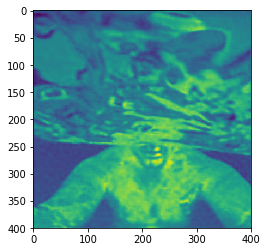

In [37]:
plt.imshow(np.squeeze(Y_pred)[:,:,1])

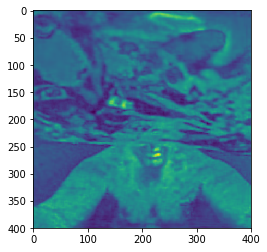

In [38]:
plt.imshow(np.squeeze(Y_pred)[:,:,0])

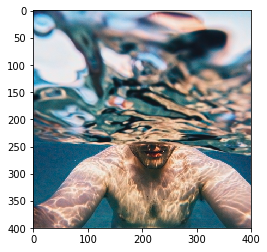

In [40]:
plt.imshow(lab2rgb(output))

In [39]:
imsave("pytorch_img_result_swim.png", lab2rgb(output))

/home/Jagan/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
